## Modelo de Clasificación de Géneros

[Analisis de dimensiones dentro de la red convolucional](https://towardsdatascience.com/a-comprehensible-explanation-of-the-dimensions-in-cnns-841dba49df5e)

[Proyecto 1](https://www.kaggle.com/datasets/mmoreaux/environmental-sound-classification-50)

Using as a baseline the following architecture (2010) [Link](https://ieeexplore.ieee.org/document/9122698)

Data set: clasificación de emociones RAVDESS

In [10]:
import torchaudio
import numpy as np
import tensorflow

import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization, ELU, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

In [11]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

## Data Preprocesada

In [12]:
# open file in read mode and read data 
filename = 'data/processed_data/mfccs_big_and_small.npy'
with open(filename, 'rb') as f:
    Xb = np.load(f)
    yb = np.load(f)
    Xs = np.load(f)
    ys = np.load(f)
    Xbl = np.load(f)
    ybl = np.load(f)
    Xsl = np.load(f)
    ysl = np.load(f)
# Check that we've recovered the right data
print(f'Xb:{Xb.shape}, yb:{yb.shape}')
print(f'Xs:{Xs.shape}, ys:{ys.shape}')
print(f'Xb:{Xbl.shape}, yb:{ybl.shape}')
print(f'Xs:{Xsl.shape}, ys:{ysl.shape}')

Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)
Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)


## Modelo de Referencia

1 - Convolucoión en 1 dimensión

2 -  ```rho``` parámetro que controla la media variable de los gradientes y permite estabilizar el entrenamiento


In [17]:
model_1 = Sequential()

model_1.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.1))
model_1.add(MaxPooling1D(pool_size=(8)))
model_1.add(Conv1D(128, 5,padding='same',)) #padding same: la idea es que los kernels logren capturar toda la secuencia
model_1.add(Activation('relu'))
model_1.add(Dropout(0.1))
model_1.add(Flatten())
model_1.add(Dense(8))
model_1.add(Activation('softmax'))
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None)

In [18]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 40, 128)           768       
                                                                 
 activation_6 (Activation)   (None, 40, 128)           0         
                                                                 
 dropout_4 (Dropout)         (None, 40, 128)           0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 activation_7 (Activation)   (None, 5, 128)            0         
                                                      

In [19]:
model_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Separando nuestros datos para entrenar

In [21]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Xb, yb, test_size=0.10, random_state=42)

In [22]:
x_traincnn_b = np.expand_dims(X_train_b, axis=2)
x_testcnn_b = np.expand_dims(X_test_b, axis=2)
y_train_b = (y_train_b - 1).astype(int)
y_test_b = (y_test_b - 1).astype(int)

In [32]:
np.unique(y_train_b)

array([0, 1, 2, 3, 4, 5, 6, 7])

## Entrenamos

In [23]:
cnnhistory_m1=model_1.fit(x_traincnn_b, np.array(y_train_b), batch_size=16, epochs=204, validation_data=(x_testcnn_b, np.array(y_test_b)))

Epoch 1/204
81/81 [==============================] - 0s 3ms/step - loss: 6.6268 - accuracy: 0.1335 - val_loss: 2.3614 - val_accuracy: 0.1806
Epoch 2/204
81/81 [==============================] - 0s 2ms/step - loss: 5.6013 - accuracy: 0.1381 - val_loss: 2.3463 - val_accuracy: 0.1597
Epoch 3/204
81/81 [==============================] - 0s 2ms/step - loss: 4.9855 - accuracy: 0.1512 - val_loss: 1.8701 - val_accuracy: 0.3056
Epoch 4/204
81/81 [==============================] - 0s 2ms/step - loss: 4.6294 - accuracy: 0.1667 - val_loss: 1.9149 - val_accuracy: 0.3194
Epoch 5/204
81/81 [==============================] - 0s 2ms/step - loss: 4.3864 - accuracy: 0.1551 - val_loss: 1.8032 - val_accuracy: 0.2917
Epoch 6/204
81/81 [==============================] - 0s 2ms/step - loss: 3.7870 - accuracy: 0.1844 - val_loss: 1.8148 - val_accuracy: 0.3264
Epoch 7/204
81/81 [==============================] - 0s 2ms/step - loss: 3.4656 - accuracy: 0.1813 - val_loss: 1.8064 - val_accuracy: 0.3056
Epoch 8/204
8

## Metricas

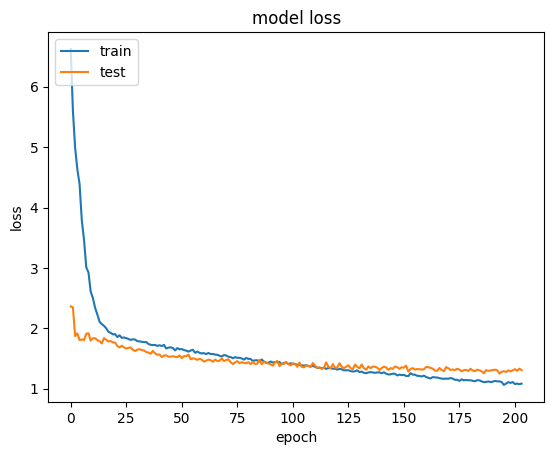

In [24]:
plt.plot(cnnhistory_m1.history['loss'])
plt.plot(cnnhistory_m1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

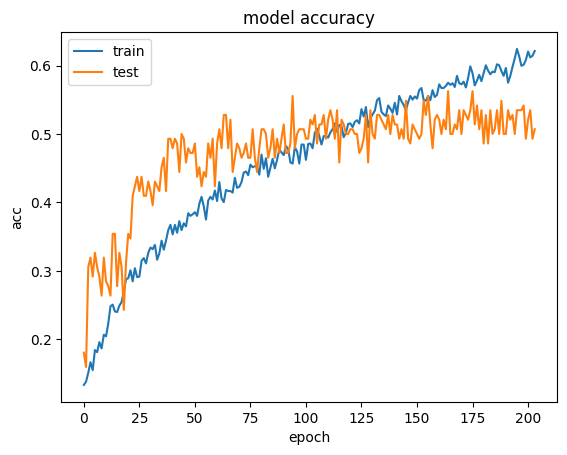

In [25]:
plt.plot(cnnhistory_m1.history['accuracy'])
plt.plot(cnnhistory_m1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()